## Simple CNN model

In [86]:
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [102]:
class CNNsimple(nn.Module):
    def __init__(self):
        super(CNNsimple, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(2 * 8 * 8, 16)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [103]:
def train_model(model, criterion, train_loader, validation_loader, optimizer, scheduler, epochs=30):
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        scheduler.step()

## Unmatched halves without hyperparameter tuning

### Load data

In [104]:
from dataloaders import SKLMatchedPairsCGL
from evaluation import evaluate

data0_dir = Path('data/b_0_c_1_dT_01_t_1e03/')
data1_dir = Path('data/b_0_c_1_dT_01_t_1e04/')

data = SKLMatchedPairsCGL(data0_dir, data1_dir, train_match='unmatched_halves', seed=1234)
X_train, y_train, X_dev, y_dev, X_test, y_test = data.X_train, data.y_train, data.X_dev, data.y_dev, data.X_test, data.y_test
X_train = X_train.reshape((6000, 2, 32, 32))
X_dev = X_dev.reshape((2000, 2, 32, 32))
X_test = X_test.reshape((2000, 2, 32, 32))

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_dev_tensor = torch.tensor(X_dev, dtype=torch.float32)
y_dev_tensor = torch.tensor(y_dev, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
validation_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=2000, shuffle=False)

### Fit model and Evaluate

In [105]:
runs = 10
results = []

for random_state in range(runs):
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    
    model = CNNsimple()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    train_model(model, criterion, train_loader, validation_loader, optimizer, scheduler, epochs=50)
    
    model.eval()
    with torch.no_grad():
        y_preds = torch.sigmoid(model(X_test_tensor)) >= 0.5
        y_preds = np.array(y_preds.squeeze())
    eval_metrics = evaluate(y_preds,y_test)
    results.append(eval_metrics)

print(results)

accuracies = np.array([run['accuracy'] for run in results])
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies, ddof=1)

print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")

[{'accuracy': 0.6805, 'PPV': 0.6562770562770562, 'NPV': 0.7136094674556213, 'sensitivity': 0.758, 'specificity': 0.603, 'F-score': 0.7034802784222738}, {'accuracy': 0.5685, 'PPV': 0.6340508806262231, 'NPV': 0.5460040295500336, 'sensitivity': 0.324, 'specificity': 0.813, 'F-score': 0.42885506287227}, {'accuracy': 0.6665, 'PPV': 0.6611810261374637, 'NPV': 0.672182006204757, 'sensitivity': 0.683, 'specificity': 0.65, 'F-score': 0.6719134284308903}, {'accuracy': 0.6495, 'PPV': 0.6365296803652968, 'NPV': 0.6651933701657459, 'sensitivity': 0.697, 'specificity': 0.602, 'F-score': 0.6653937947494033}, {'accuracy': 0.682, 'PPV': 0.6627906976744186, 'NPV': 0.7063492063492064, 'sensitivity': 0.741, 'specificity': 0.623, 'F-score': 0.6997167138810199}, {'accuracy': 0.7215, 'PPV': 0.6990116801437556, 'NPV': 0.7497181510710259, 'sensitivity': 0.778, 'specificity': 0.665, 'F-score': 0.7363937529578798}, {'accuracy': 0.617, 'PPV': 0.6046511627906976, 'NPV': 0.6326530612244898, 'sensitivity': 0.676, 's

## Matched pairs without hyperparameter tuning

### Load data

In [106]:
from dataloaders import SKLMatchedPairsCGL
from evaluation import evaluate

data0_dir = Path('data/b_0_c_1_dT_01_t_1e03/')
data1_dir = Path('data/b_0_c_1_dT_01_t_1e04/')

data = SKLMatchedPairsCGL(data0_dir, data1_dir, train_match='half_matches', seed=1234)
X_train, y_train, X_dev, y_dev, X_test, y_test = data.X_train, data.y_train, data.X_dev, data.y_dev, data.X_test, data.y_test
X_train = X_train.reshape((6000, 2, 32, 32))
X_dev = X_dev.reshape((2000, 2, 32, 32))
X_test = X_test.reshape((2000, 2, 32, 32))

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_dev_tensor = torch.tensor(X_dev, dtype=torch.float32)
y_dev_tensor = torch.tensor(y_dev, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
validation_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=2000, shuffle=False)

### Fit model and Evaluate

In [107]:
runs = 10
results = []

for random_state in range(runs):
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    
    model = CNNsimple()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    train_model(model, criterion, train_loader, validation_loader, optimizer, scheduler, epochs=50)
    
    model.eval()
    with torch.no_grad():
        y_preds = torch.sigmoid(model(X_test_tensor)) >= 0.5
        y_preds = np.array(y_preds.squeeze())
    eval_metrics = evaluate(y_preds,y_test)
    results.append(eval_metrics)

print(results)

accuracies = np.array([run['accuracy'] for run in results])
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies, ddof=1)

print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")

[{'accuracy': 0.69, 'PPV': 0.668141592920354, 'NPV': 0.7183908045977011, 'sensitivity': 0.755, 'specificity': 0.625, 'F-score': 0.7089201877934272}, {'accuracy': 0.677, 'PPV': 0.6644981412639405, 'NPV': 0.6915584415584416, 'sensitivity': 0.715, 'specificity': 0.639, 'F-score': 0.6888246628131021}, {'accuracy': 0.6585, 'PPV': 0.6519654841802492, 'NPV': 0.6656217345872518, 'sensitivity': 0.68, 'specificity': 0.637, 'F-score': 0.6656877141458639}, {'accuracy': 0.6585, 'PPV': 0.6360515021459228, 'NPV': 0.6898203592814371, 'sensitivity': 0.741, 'specificity': 0.576, 'F-score': 0.684526558891455}, {'accuracy': 0.6815, 'PPV': 0.6645512239347234, 'NPV': 0.7023411371237458, 'sensitivity': 0.733, 'specificity': 0.63, 'F-score': 0.6970993818354732}, {'accuracy': 0.722, 'PPV': 0.7010869565217391, 'NPV': 0.7477678571428571, 'sensitivity': 0.774, 'specificity': 0.67, 'F-score': 0.7357414448669202}, {'accuracy': 0.5995, 'PPV': 0.5845369583687341, 'NPV': 0.6208991494532199, 'sensitivity': 0.688, 'spec

## All matched pairs

### Load data

In [108]:
from dataloaders import SKLMatchedPairsCGL
from evaluation import evaluate

data0_dir = Path('data/b_0_c_1_dT_01_t_1e03/')
data1_dir = Path('data/b_0_c_1_dT_01_t_1e04/')

data = SKLMatchedPairsCGL(data0_dir, data1_dir, train_match='all_matches', seed=1234)
X_train, y_train, X_dev, y_dev, X_test, y_test = data.X_train, data.y_train, data.X_dev, data.y_dev, data.X_test, data.y_test
X_train = X_train.reshape((12000, 2, 32, 32))
X_dev = X_dev.reshape((2000, 2, 32, 32))
X_test = X_test.reshape((2000, 2, 32, 32))

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_dev_tensor = torch.tensor(X_dev, dtype=torch.float32)
y_dev_tensor = torch.tensor(y_dev, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
validation_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=2000, shuffle=False)

### Fit model and Evaluate

In [109]:
runs = 10
results = []

for random_state in range(runs):
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    
    model = CNNsimple()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    train_model(model, criterion, train_loader, validation_loader, optimizer, scheduler, epochs=50)
    
    model.eval()
    with torch.no_grad():
        y_preds = torch.sigmoid(model(X_test_tensor)) >= 0.5
        y_preds = np.array(y_preds.squeeze())
    eval_metrics = evaluate(y_preds,y_test)
    results.append(eval_metrics)

print(results)

accuracies = np.array([run['accuracy'] for run in results])
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies, ddof=1)

print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")

[{'accuracy': 0.649, 'PPV': 0.618066561014263, 'NPV': 0.7018970189701897, 'sensitivity': 0.78, 'specificity': 0.518, 'F-score': 0.6896551724137931}, {'accuracy': 0.639, 'PPV': 0.743859649122807, 'NPV': 0.5972027972027972, 'sensitivity': 0.424, 'specificity': 0.854, 'F-score': 0.5401273885350318}, {'accuracy': 0.6855, 'PPV': 0.6738519212746017, 'NPV': 0.6988210075026795, 'sensitivity': 0.719, 'specificity': 0.652, 'F-score': 0.6956942428640541}, {'accuracy': 0.73, 'PPV': 0.697934595524957, 'NPV': 0.7744630071599046, 'sensitivity': 0.811, 'specificity': 0.649, 'F-score': 0.750231267345051}, {'accuracy': 0.7455, 'PPV': 0.739980449657869, 'NPV': 0.7512794268167861, 'sensitivity': 0.757, 'specificity': 0.734, 'F-score': 0.7483934750370737}, {'accuracy': 0.784, 'PPV': 0.7610294117647058, 'NPV': 0.8114035087719298, 'sensitivity': 0.828, 'specificity': 0.74, 'F-score': 0.793103448275862}, {'accuracy': 0.6775, 'PPV': 0.663594470046083, 'NPV': 0.6939890710382514, 'sensitivity': 0.72, 'specificit

## Parameter tuning

### Model Construction

In [110]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, conv_layers, kernel_size, fc_neurons, use_batchnorm=False):
        super(CNN, self).__init__()
        layers = []
        in_channels = 2

        for _, out_channels in enumerate(conv_layers):
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
            layers.append(conv)
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = out_channels

        self.conv = nn.Sequential(*layers)

        num_pools = len(conv_layers)
        spatial_size = 32 // (2 ** num_pools)
        self.flatten_size = conv_layers[-1] * spatial_size * spatial_size

        self.fc = nn.Sequential(
            nn.Linear(self.flatten_size, fc_neurons),
            nn.ReLU(),
            nn.Linear(fc_neurons, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, self.flatten_size)
        x = self.fc(x)
        return x


### train model

In [111]:
def train_model(model, criterion, train_loader, validation_loader, optimizer, scheduler, epochs=50):

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        scheduler.step()

### load data

In [112]:
from dataloaders import SKLMatchedPairsCGL
from evaluation import evaluate
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset

data0_dir = Path('data/b_0_c_1_dT_01_t_1e03/')
data1_dir = Path('data/b_0_c_1_dT_01_t_1e04/')

data = SKLMatchedPairsCGL(data0_dir, data1_dir, train_match='unmatched_halves', seed=1234)
X_train, y_train, X_dev, y_dev, X_test, y_test = data.X_train, data.y_train, data.X_dev, data.y_dev, data.X_test, data.y_test
X_train = X_train.reshape((6000, 2, 32, 32))
X_dev = X_dev.reshape((2000, 2, 32, 32))
X_test = X_test.reshape((2000, 2, 32, 32))

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_dev_tensor = torch.tensor(X_dev, dtype=torch.float32)
y_dev_tensor = torch.tensor(y_dev, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
validation_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=2000, shuffle=False)

### iterate through hyperparameter combinations

In [113]:
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm

runs = 4
conv_options = [[2, 2], [2, 8], [8, 2], [8, 32], [32, 8], [2, 8, 32]]
kernel_size_options = [2, 4, 8]
normalization_options = [True, False]
fc_neurons_options = [2, 8, 32]


hyperparameter_combinations = list(itertools.product(
    conv_options, kernel_size_options, normalization_options, fc_neurons_options))
print(f"Total hyperparameter combinations: {len(hyperparameter_combinations)}")

results = []
for idx, (conv_layers, kernel_size, use_batchnorm, fc_neurons) in enumerate(hyperparameter_combinations):
    for run in tqdm(range(runs), desc=f"Hyperparameter Set {idx+1}/{len(hyperparameter_combinations)}"):

        random_state = run
        torch.manual_seed(random_state)
        np.random.seed(random_state)
        
        model = CNN(conv_layers=conv_layers,
                    kernel_size=kernel_size,
                    fc_neurons=fc_neurons,
                    use_batchnorm=use_batchnorm)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        train_model(model, criterion, train_loader, validation_loader, optimizer, scheduler, epochs=50)
        
        model.eval()
        with torch.no_grad():
            y_preds = torch.sigmoid(model(X_test_tensor)) >= 0.5
            y_preds = np.array(y_preds.squeeze())
            eval_metrics = evaluate(y_preds, y_test)

        results.append({
            'conv_layers': conv_layers,
            'kernel_size': kernel_size,
            'use_batchnorm': use_batchnorm,
            'fc_neurons': fc_neurons,
            'run': run,
            **eval_metrics
        })

Total hyperparameter combinations: 108


Hyperparameter Set 1/108:  75%|███████▌  | 3/4 [01:25<00:29, 29.30s/it]/Users/wenj/cgl-stability-classifiers/evaluation.py:28: RuntimeWarning: invalid value encountered in long_scalars
  eval_metrics['PPV'] = confusion[1, 1]/np.sum(confusion[1])
/Users/wenj/cgl-stability-classifiers/evaluation.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  eval_metrics['F-score'] = 2.0/(1.0/eval_metrics['PPV']+1.0/eval_metrics['sensitivity'])
Hyperparameter Set 4/108:   0%|          | 0/4 [00:00<?, ?it/s]/Users/wenj/cgl-stability-classifiers/evaluation.py:29: RuntimeWarning: invalid value encountered in long_scalars
  eval_metrics['NPV'] = confusion[0, 0]/np.sum(confusion[0])
Hyperparameter Set 108/108: 100%|██████████| 4/4 [07:47<00:00, 116.90s/it]


### plot the results

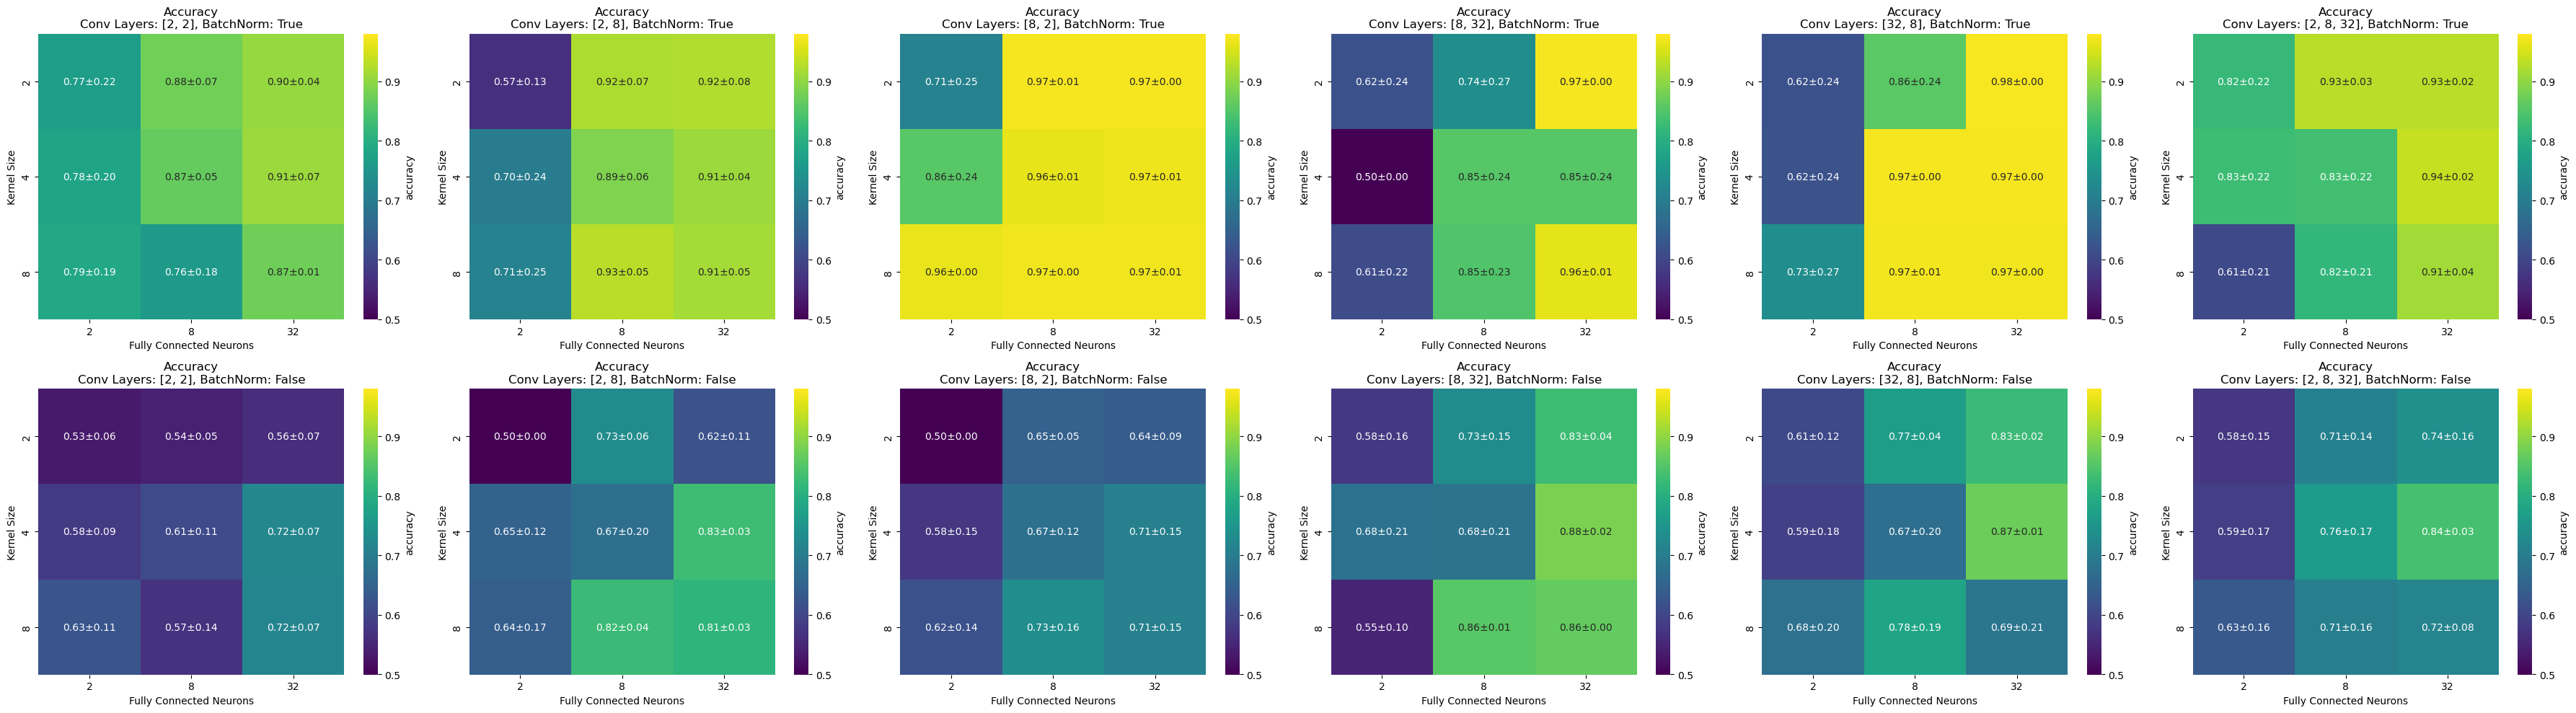

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

metrics_df = pd.DataFrame(results)
metrics_df.to_csv('CNN.csv', index=False)

n_conv_layers = len(conv_options)
n_batchnorm = len(normalization_options)
fig, axes = plt.subplots(nrows = n_batchnorm, ncols = n_conv_layers, figsize = ( n_conv_layers * 6, n_batchnorm * 5) )

vmin = metrics_df['accuracy'].min()
vmax = metrics_df['accuracy'].max()

for i, batchnorm in enumerate(normalization_options):
    for j, conv_layer in enumerate(conv_options):
        subset_df = metrics_df[ metrics_df['conv_layers'].apply(lambda x: x == conv_layer) & (metrics_df['use_batchnorm'] == batchnorm)]

        grouped = subset_df.groupby(['kernel_size', 'fc_neurons'])['accuracy'].agg(['mean', 'std'])
        mean_df = grouped.reset_index().pivot(index='kernel_size', columns='fc_neurons', values='mean')
        std_df = grouped.reset_index().pivot(index='kernel_size', columns='fc_neurons', values='std')

        annotations = mean_df.copy().astype(str)
        for ks in mean_df.index:
            for fc in mean_df.columns:
                mean_val = mean_df.loc[ks, fc]
                std_val = std_df.loc[ks, fc]
                if not np.isnan(mean_val):
                    annotations.loc[ks, fc] = f"{mean_val:.2f}±{std_val:.2f}"
                else:
                    annotations.loc[ks, fc] = ''

        ax = axes[i, j]
        sns.heatmap(data = mean_df.astype(float), vmin = vmin, vmax = vmax, annot = annotations, fmt = '',
                    cmap = 'viridis', ax = ax, cbar = True, cbar_kws = {"label": 'accuracy'})
        ax.set_title(f'Accuracy\nConv Layers: {conv_layer}, BatchNorm: {batchnorm}')
        ax.set_xlabel('Fully Connected Neurons')
        ax.set_ylabel('Kernel Size')

plt.tight_layout()
plt.show()


## Train final model and interpret

In [40]:
model = CNN(conv_layers=[8, 2], kernel_size=4, fc_neurons=32, use_batchnorm=True)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_model(model, criterion, train_loader, validation_loader, optimizer, scheduler, epochs=50)

In [83]:
current_input = X_test_tensor[0:1]
conv_layer = []
feature_maps = []
for layer in model.conv:
    current_input = layer(current_input)
    if isinstance(layer, nn.Conv2d):
        conv_layer.append(layer)
        feature_maps.append(current_input.detach())


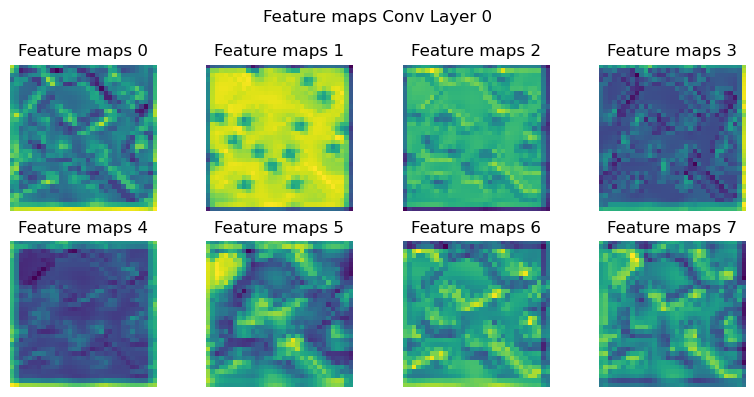

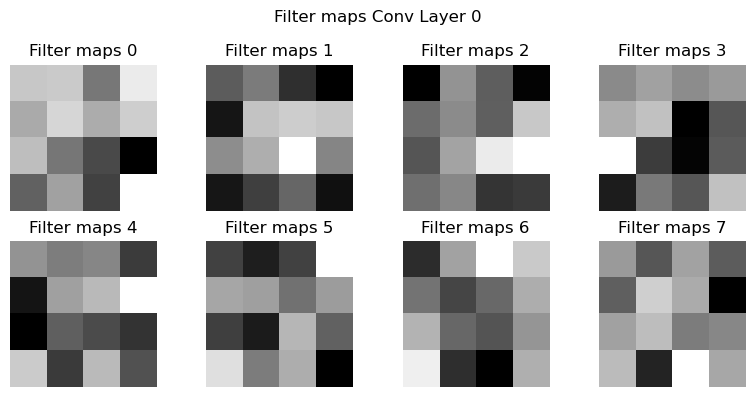

In [85]:
import matplotlib.pyplot as plt

def plot_maps(maps, layer_num, map_type, cmap='viridis'):

    num_maps = maps.shape[0]
    cols = int(num_maps / 2)
    rows = 2
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()
    
    for i in range(num_maps):
        ax = axes[i]
        ax.imshow(maps[i, :, :], cmap=cmap)
        ax.axis('off')
        ax.set_title(f'{map_type} {i}')
    
    fig.suptitle(f'{map_type} Conv Layer {layer_num}')
    plt.tight_layout()
    plt.show()

plot_maps(feature_maps[0][0, :, :, :], layer_num=0, map_type='Feature maps')
plot_maps(conv_layer[0].weight.detach()[:, 0, :, :], layer_num=0, map_type='Filter maps', cmap='gray')
